In [1]:
# %load genetic_algorithm.py
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
# import main_func
import facebook_datacollector
import pandas as pd
import mysql_adactivity_save

# sizepop, vardim, MAXGEN, params = 2000, 3, 30, [0.9, 0.5, 0.5]
sizepop, vardim, MAXGEN, params = 1000, 3, 15, [0.9, 0.5, 0.5]
BRANDING_CAMPAIGN_LIST = [
    'LINK_CLICKS', 'ALL_CLICKS','VIDEO_VIEWS', 'REACH', 'IMPRESSIONS', 'POST_ENGAGEMENT', 'PAGE_LIKES', 'LANDING_PAGE_VIEW']
PERFORMANCE_CAMPAIGN_LIST = [
    'CONVERSIONS', 'LEAD_GENERATION', 'ADD_TO_CART']
class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print ("Optimal solution is:")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()

class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitnessfunc( self.chrom, df )
        
class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def fitnessfunc(optimal_weight, df):
        m_kpi   = df['campaign_charge'] / df['charge_per_day']
        m_spend = -( df['budget_per_day'] - df['spend'] ) / df['budget_per_day']
        m_bid   = ( df['campaign_bid'] - df['campaign_cpc'] ) / df['campaign_bid']

        status  = np.array( [m_kpi, m_spend, m_bid] )
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df):
        df = df.fillna(0)
        m_kpi = df['target'] / df['daily_charge'] * 10
        if df['target'].iloc[0] == 0:
            m_kpi = -10
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['bid_amount'] - df['cost_per_target'] ) / df['bid_amount']
        status  = np.array( [m_kpi, m_spend.iloc[0], m_bid.iloc[0]] )

        for idx, j in enumerate(status):
            if np.isinf(idx) or np.isneginf(idx):
                status[idx] = -100
        status = np.nan_to_num(status)
        optimal_weight = np.array([
            optimal_weight['weight_kpi'].iloc[0],
            optimal_weight['weight_spend'].iloc[0],
            optimal_weight['weight_bid'].iloc[0]
        ])
        r = np.dot( optimal_weight, status )
        return r
    
    def campaign_status( campaign_id ):

        mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %(campaign_id), con=mydb)
        print(df_camp)
        charge_type = df_camp['charge_type'].iloc[0]
        df_camp['charge_per_day'] = df_camp['target']/df_camp['period']
        df_camp['campaign_bid'] = df_camp['ai_spend_cap']/df_camp['destination']
        df_camp['budget_per_day'] = df_camp['daily_budget']
        df_camp['charge_per_day'] = df_camp['daily_charge']
        
        campaign_collector = facebook_datacollector.Campaigns(campaign_id, charge_type)
        insights = campaign_collector.get_campaign_insights()
        wanted_key_list = ['target', 'cost_per_target', 'impressions', 'spend']

        unwanted_key_list = set(insights) - set(wanted_key_list)
        for unwanted_key in unwanted_key_list: del insights[unwanted_key]
        
        df_insights = pd.DataFrame(insights, index=[0])
        df_insights = df_insights.rename(columns = {
            'target':'campaign_charge',
            'cost_per_target':'campaign_cpc'
        })
        
        df = pd.concat([ df_insights, df_camp[['campaign_id', 'charge_per_day', 'budget_per_day', 'daily_budget', 'daily_charge', 'charge_type', 'campaign_bid']] ], axis=1)
        df = df.convert_objects(convert_numeric=True)
        mydb.close()
        return df
    
    def adset_status( adset_id, df_camp ):
        charge_type = df_camp['charge_type'].iloc[0]
        adset_collector = facebook_datacollector.AdSets(adset_id, charge_type)
        ### Campaign lifetime insights
        df_camp['campaign_daily_budget'] = df_camp['daily_budget']
        df_camp[['campaign_id', 'daily_charge', 'campaign_daily_budget']]
        ### Adset lifetime insights
        
        insights = adset_collector.generate_adset_info()
        
        wanted_key_list = ['adset_id', 'target', 'cost_per_target', 'impressions', 'reach', 'spend', 'bid_amount']

        unwanted_key_list = set(insights) - set(wanted_key_list)
        for unwanted_key in unwanted_key_list: del insights[unwanted_key]
        
        df_adset = pd.DataFrame(insights, index=[0])
        df = pd.concat(
            [df_camp[['campaign_id', 'daily_charge', 'daily_budget', 'campaign_daily_budget']], df_adset], ignore_index=True, sort=True)
        df = df.convert_objects(convert_numeric=True)
        return df

def ga_optimal_weight(campaign_id):
    request_time = datetime.datetime.now().date()
    mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )
    df_weight = pd.read_sql("SELECT * FROM optimal_weight WHERE campaign_id=%s " %(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s " %(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = facebook_datacollector.Campaigns(campaign_id, charge_type).get_adsets_active()
    if len(df_weight) > 0:
        for adset_id in adset_list:
            df = ObjectiveFunc.adset_status( adset_id, df_camp )
            r = ObjectiveFunc.adset_fitness( df_weight, df )
            print('[score]', r)
            df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r, 'request_time':request_time}, index=[0])
            try:
                mysql_adactivity_save.intoDB("adset_score", df_final)
            except Exception as e:
                print('score is inf: ', e)
                pass
    else:
        pass
    mydb.close()
    return

def main(campaign_id=None):
    starttime = datetime.datetime.now()
    global df
    if not campaign_id:
        camp_id_list = mysql_adactivity_save.get_running_branding_campaign()['campaign_id'].unique()
        for camp_id in camp_id_list:
            print('campaign_id:', camp_id )
            print('current time: ', starttime )
            df = ObjectiveFunc.campaign_status(camp_id)
            bound = np.tile([[0], [1]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc.fitnessfunc(optimal, df)

            score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
            df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])

            df_final = pd.DataFrame({'campaign_id':camp_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
            df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)

            print(df_final)
            mysql_adactivity_save.check_optimal_weight(camp_id, df_final)
            ga_optimal_weight(camp_id)

            print('optimal_weight:', optimal)
            print(datetime.datetime.now()-starttime)    
        print(datetime.datetime.now()-starttime)
    else:
        print('campaign_id:', campaign_id )
        print('current time: ', starttime )
        df = ObjectiveFunc.campaign_status(campaign_id)
        print(df)
        if df['charge_type'].iloc[0] in BRANDING_CAMPAIGN_LIST:
            bound = np.tile([[0], [1]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc.fitnessfunc(optimal, df)

            score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
            df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])

            df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
            df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)

            print(df_final)
            mysql_adactivity_save.check_optimal_weight(campaign_id, df_final)
            ga_optimal_weight(campaign_id)

            print('optimal_weight:', optimal)
    return


campaign_id: 23843358370700576
current time:  2019-07-09 10:59:02.465481
         campaign_id  destination destination_max  charge_type is_optimized  \
0  23843358370700576        18750            None  VIDEO_VIEWS         True   

  optimized_date  cost_per_target  daily_budget  daily_charge  impressions  \
0     2019-07-09         0.426983         300.0       1034.33       109187   

   ... ai_start_date  ai_stop_date  ai_status  spend_cap          start_time  \
0  ...    2019-06-17    2019-07-11     active     106000 2019-05-13 00:01:36   

            stop_time target  target_left  target_type  reach  
0 2019-07-11 23:59:00  15647         3103  VIDEO_VIEWS  45821  

[1 rows x 24 columns]


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:267: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: -0.971786; average function value is -0.947063
Generation 1: optimal function value is: 36.547635; average function value is 21.674015
Generation 2: optimal function value is: 36.654212; average function value is 22.994069
Generation 3: optimal function value is: 36.654212; average function value is 24.308567
Generation 4: optimal function value is: 36.654212; average function value is 24.942275
Generation 5: optimal function value is: 36.654212; average function value is 25.825438
Generation 6: optimal function value is: 36.654212; average function value is 26.482136
Generation 7: optimal function value is: 36.654212; average function value is 27.229934
Generation 8: optimal function value is: 36.654212; average function value is 27.454905
Generation 9: optimal function value is: 36.654212; average function value is 27.829278
Generation 10: optimal function value is: 36.654212; average function value is 28.040300
Generation 11: optimal function

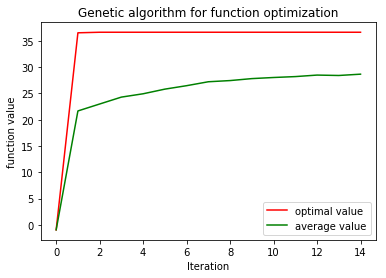

   weight_kpi  weight_spend  weight_bid        campaign_id      score
0    0.987759      0.995081    0.577532  23843358370700576  36.654212
[get_adsets_active] adset_active_list: ['23843490797000576', '23843490796290576', '23843490795740576', '23843490793880576', '23843490785360576']


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:289: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


[score] -10.872671000000002
[score] -10.872671000000002
[score] -10.872671000000002
[score] -10.872671000000002
[score] -10.872671000000002
optimal_weight: [0.98775856 0.99508069 0.57753183]
0:00:38.207807
campaign_id: 23843546765400616
current time:  2019-07-09 10:59:02.465481
         campaign_id  destination destination_max  charge_type is_optimized  \
0  23843546765400616         4062            None  LINK_CLICKS        False   

  optimized_date  cost_per_target  daily_budget  daily_charge  impressions  \
0     2019-07-09          6.63283       527.532      -42.4091       246829   

   ... ai_start_date  ai_stop_date  ai_status  spend_cap          start_time  \
0  ...    2019-05-15    2019-07-30     active      40620 2019-05-03 18:27:05   

            stop_time target  target_left  target_type  reach  
0 2019-07-30 23:59:00   4995         -933  LINK_CLICKS  98944  

[1 rows x 24 columns]
Generation 0: optimal function value is: -0.983165; average function value is -1.033150
Gener

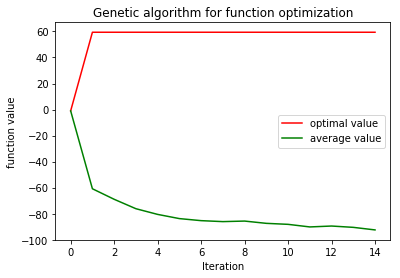

   weight_kpi  weight_spend  weight_bid        campaign_id      score
0     0.01505      0.986293    0.640077  23843546765400616  59.399524
[get_adsets_active] adset_active_list: ['23843587553620616', '23843587552180616']
[score] -1.136792
[score] -1.136792
optimal_weight: [0.01504993 0.98629255 0.64007688]
0:01:13.960445
campaign_id: 23843494059550273
current time:  2019-07-09 10:59:02.465481
         campaign_id  destination destination_max      charge_type  \
0  23843494059550273        14675            None  POST_ENGAGEMENT   

  is_optimized optimized_date  cost_per_target  daily_budget  daily_charge  \
0         True     2019-07-08           0.0875        3086.0        1365.0   

   impressions  ... ai_start_date  ai_stop_date  ai_status  spend_cap  \
0        59206  ...    2019-06-21    2019-07-15     active      72727   

           start_time           stop_time target  target_left  \
0 2019-06-20 11:47:31 2019-07-15 23:59:00   5120         9555   

       target_type  reach  

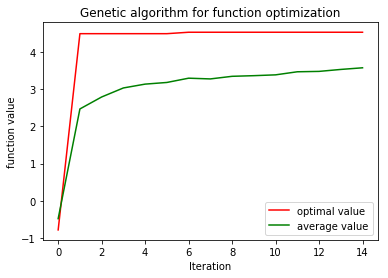

   weight_kpi  weight_spend  weight_bid        campaign_id     score
0    0.987905      0.109468    0.929198  23843494059550273  4.524797
[get_adsets_active] adset_active_list: ['23843541660220273', '23843541659720273', '23843541659200273', '23843541658690273']
[score] -9.988518
[score] -9.988518
[score] -9.988518
[score] -9.988518
optimal_weight: [0.98790457 0.10946782 0.92919787]
0:01:51.135472
campaign_id: 23843431154770620
current time:  2019-07-09 10:59:02.465481
         campaign_id  destination destination_max charge_type is_optimized  \
0  23843431154770620         6000            None  ALL_CLICKS        False   

  optimized_date  cost_per_target  daily_budget  daily_charge  impressions  \
0     2019-07-08          5.43452       882.353         157.2       158220   

   ... ai_start_date  ai_stop_date  ai_status  spend_cap          start_time  \
0  ...    2019-06-25    2019-07-28     active       None 2019-06-03 00:01:59   

            stop_time target target_left  target_typ

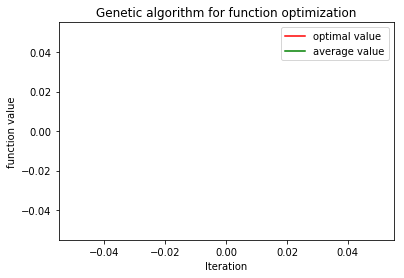

   weight_kpi  weight_spend  weight_bid        campaign_id  score
0    0.038498      0.217491    0.112551  23843431154770620    NaN
[get_adsets_active] adset_active_list: ['23843503622480620', '23843503622470620', '23843503622460620', '23843492114950620', '23843486763090620', '23843486761840620', '23843486760410620', '23843486759330620', '23843486757940620', '23843486756540620', '23843431185800620', '23843431182060620', '23843431180230620', '23843431178820620', '23843431176080620', '23843431154750620']
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471
[score] -0.602471


KeyboardInterrupt: 

In [2]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(campaign_id=23843467729120098)

In [ ]:
#!jupyter nbconvert --to script genetic_algorithm.ipynb